In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
# global variables

look_back = 20
lead_time = 1
filename = '../../../data/Arctic_Monthy_Mean_1979_2021.csv'

In [3]:
# from google.colab import files
# import io

# uploaded = files.upload()
# df = pd.read_csv(io.BytesIO(uploaded[filename]))

# Reading the dataset
df = pd.read_csv(filename)
df.head()

,Date,wind_10m,specific_humidity,LW_down,SW_down,rainfall,snowfall,sst,t2m,surface_pressure,sea_ice_extent
0,1/1/1979,5.531398,0.811961,186.687054,3.127880,1.009872,0.892319,273.355237,250.388101,984.633032,15604191
1,2/1/1979,5.328020,0.688896,174.794571,18.541594,0.920831,0.781347,273.121885,247.071202,983.980418,16378929
2,3/1/1979,5.432511,0.916124,190.741933,67.690429,0.983327,0.855266,273.088099,252.954138,985.140468,16521089
3,4/1/1979,4.792836,1.272056,212.937925,156.223673,0.890723,0.705203,273.126062,259.557456,989.314698,15561238
4,5/1/1979,4.819028,2.239776,253.690478,230.950833,1.201308,0.688723,273.393551,269.375118,984.483658,14085613


In [4]:
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df.set_index('Date', inplace=True)
df = df.astype(float)                 # cast df to float
df.tail(len(df))

/tmp/ipykernel_6823/99355226.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)


,wind_10m,specific_humidity,LW_down,SW_down,rainfall,snowfall,sst,t2m,surface_pressure,sea_ice_extent
Date,,,,,,,,,,
1979-01-01,5.531398,0.811961,186.687054,3.127880,1.009872,0.892319,273.355237,250.388101,984.633032,15604191.0
1979-02-01,5.328020,0.688896,174.794571,18.541594,0.920831,0.781347,273.121885,247.071202,983.980418,16378929.0
1979-03-01,5.432511,0.916124,190.741933,67.690429,0.983327,0.855266,273.088099,252.954138,985.140468,16521089.0
1979-04-01,4.792836,1.272056,212.937925,156.223673,0.890723,0.705203,273.126062,259.557456,989.314698,15561238.0
1979-05-01,4.819028,2.239776,253.690478,230.950833,1.201308,0.688723,273.393551,269.375118,984.483658,14085613.0
...,...,...,...,...,...,...,...,...,...,...
2021-04-01,5.383687,1.529497,225.171796,156.567743,1.159049,0.929777,273.470298,263.146395,985.801841,13840000.0
2021-05-01,4.777020,2.451088,260.956781,229.604138,1.077705,0.575494,273.888627,271.557464,985.606182,12660000.0
2021-06-01,4.771453,4.176458,294.931709,244.702852,1.585094,0.360146,275.245088,278.360921,978.436682,10710000.0


In [5]:
def create_model_data (dataset, look_back, lead_time):
    dataX, dataY = [], []
    
    for i in range(len(dataset)-look_back-lead_time):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back + (lead_time-1)])
    return np.array(dataX), np.array(dataY)

In [6]:
target_index = df.columns.tolist().index('sea_ice_extent')

dataset = df.values.astype('float32')               # DataFrame converted to Numpy Array

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

X, y = create_model_data (dataset, look_back=look_back, lead_time=lead_time)
y = y[:,target_index]

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

<function matplotlib.pyplot.show(close=None, block=None)>

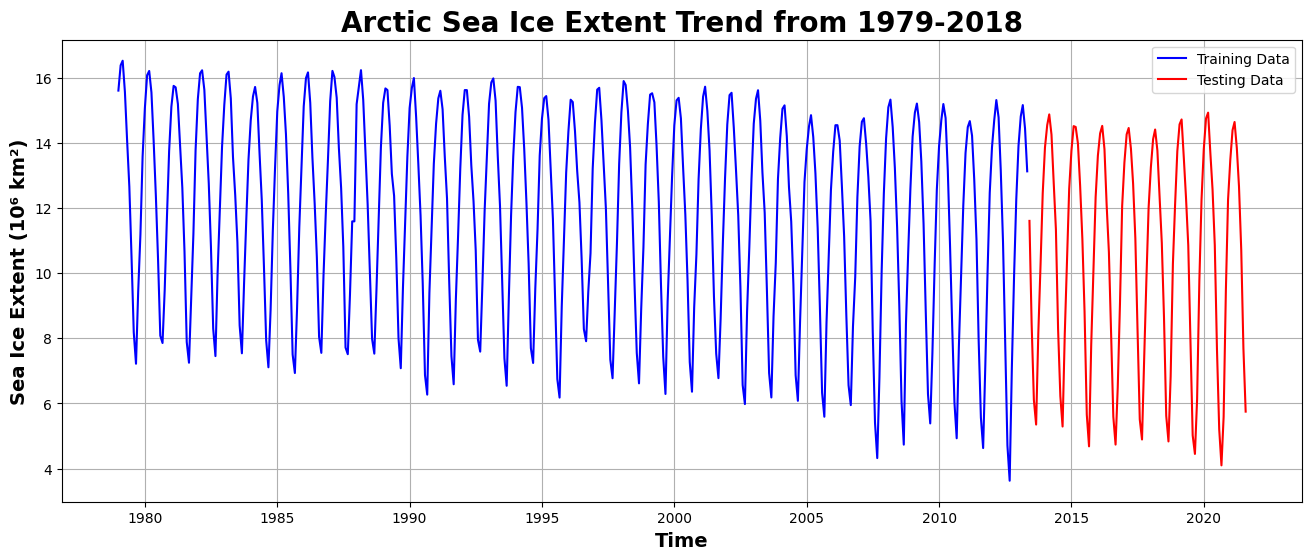

In [8]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Trend from 1979-2018', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(df['sea_ice_extent'][:len(df)-len(y_test)]/10**6, 'blue', label='Training Data')
plt.plot(df['sea_ice_extent'][len(df)-len(y_test):]/10**6, 'red', label='Testing Data')
plt.legend()
plt.grid()
plt.show

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, LSTM, GRU, Dense

input_shape=(X.shape[1], X.shape[2])

model = Sequential()
model.add(GRU(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(256, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(512, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(1024, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128))
model.add(Dropout(0.2))

model.add(Dense(64 ,  activation = 'relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
print(model.summary())

2024-11-27 18:58:19.110515: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-27 18:58:19.254388: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-27 18:58:22.355117: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 20, 64)            14592     
                                                                 
 dropout (Dropout)           (None, 20, 64)            0         
                                                                 
 gru_1 (GRU)                 (None, 20, 128)           74496     
                                                                 
 dropout_1 (Dropout)         (None, 20, 128)           0         
                                                                 
 gru_2 (GRU)                 (None, 20, 256)           296448    
                                                                 
 dropout_2 (Dropout)         (None, 20, 256)           0         
                                                                 
 gru_3 (GRU)                 (None, 20, 512)           1

In [10]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint]
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1, callbacks=callbacks_list, validation_split=0.1)

Epoch 1/100
6/6 [==============================] - 18s 973ms/step - loss: 0.7355 - mae: 0.6524 - mse: 0.7355 - val_loss: 0.1290 - val_mae: 0.3167 - val_mse: 0.1290
Epoch 2/100
6/6 [==============================] - 3s 462ms/step - loss: 0.0854 - mae: 0.2400 - mse: 0.0854 - val_loss: 0.0975 - val_mae: 0.2830 - val_mse: 0.0975
Epoch 3/100
6/6 [==============================] - 3s 431ms/step - loss: 0.0797 - mae: 0.2344 - mse: 0.0797 - val_loss: 0.0834 - val_mae: 0.2355 - val_mse: 0.0834
Epoch 4/100
6/6 [==============================] - 3s 436ms/step - loss: 0.0610 - mae: 0.2121 - mse: 0.0610 - val_loss: 0.0780 - val_mae: 0.2399 - val_mse: 0.0780
Epoch 5/100
6/6 [==============================] - 3s 442ms/step - loss: 0.0621 - mae: 0.2087 - mse: 0.0621 - val_loss: 0.0791 - val_mae: 0.2377 - val_mse: 0.0791
Epoch 6/100
6/6 [==============================] - 3s 451ms/step - loss: 0.0622 - mae: 0.2113 - mse: 0.0622 - val_loss: 0.0783 - val_mae: 0.2379 - val_mse: 0.0783
Epoch 7/100
6/6 [====

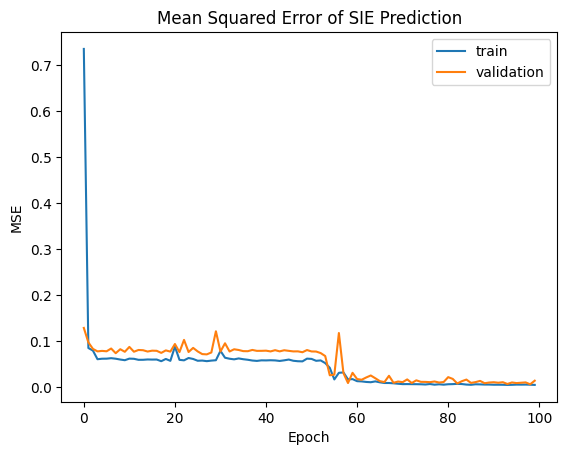

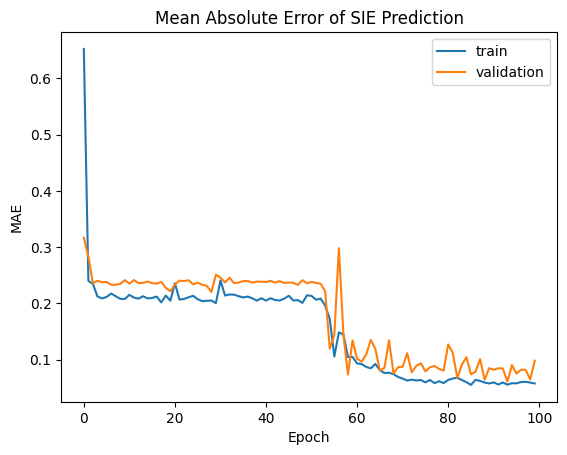

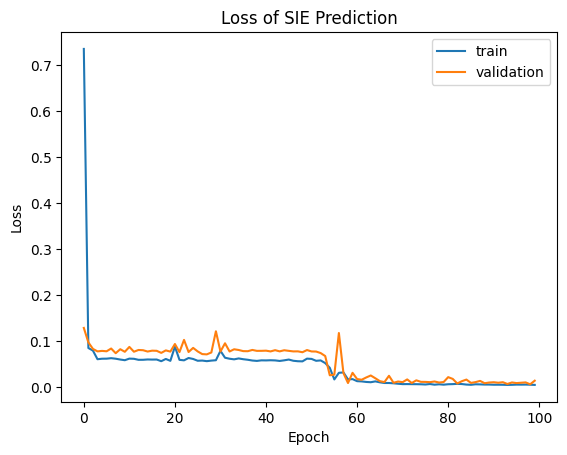

In [11]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Mean Squared Error of SIE Prediction')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Absolute Error of SIE Prediction')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of SIE Prediction')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from numpy import sqrt

#model.load_weights("weights.best.hdf5")

cols = len(df.columns)
pred = model.predict(X_test)

predicted_dataset = dataset
predicted_dataset[len(predicted_dataset)-len(pred):, cols-1] = pred[:, 0]
scaled_predicted_dataset = scaler.inverse_transform(predicted_dataset)

predicted_df = df.copy()
predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):] = scaled_predicted_dataset[len(predicted_dataset)-len(pred):, cols-1]

predictions = pd.DataFrame()
predictions['predicted'] = (predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions['actual'] = (df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions = predictions.astype(float)

4/4 [==============================] - 2s 76ms/step


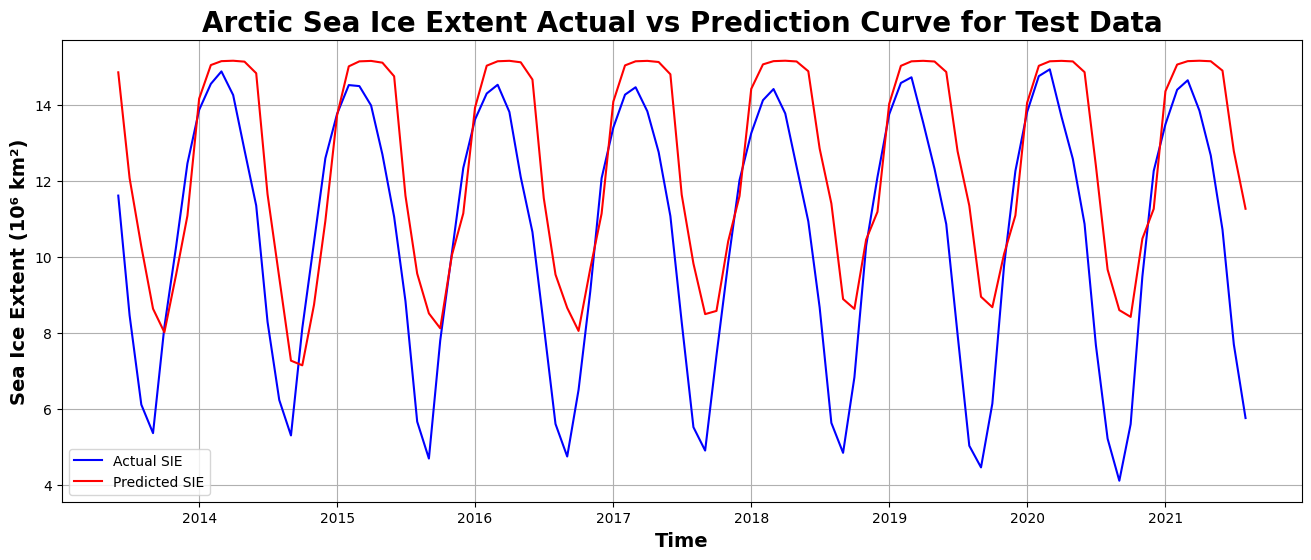

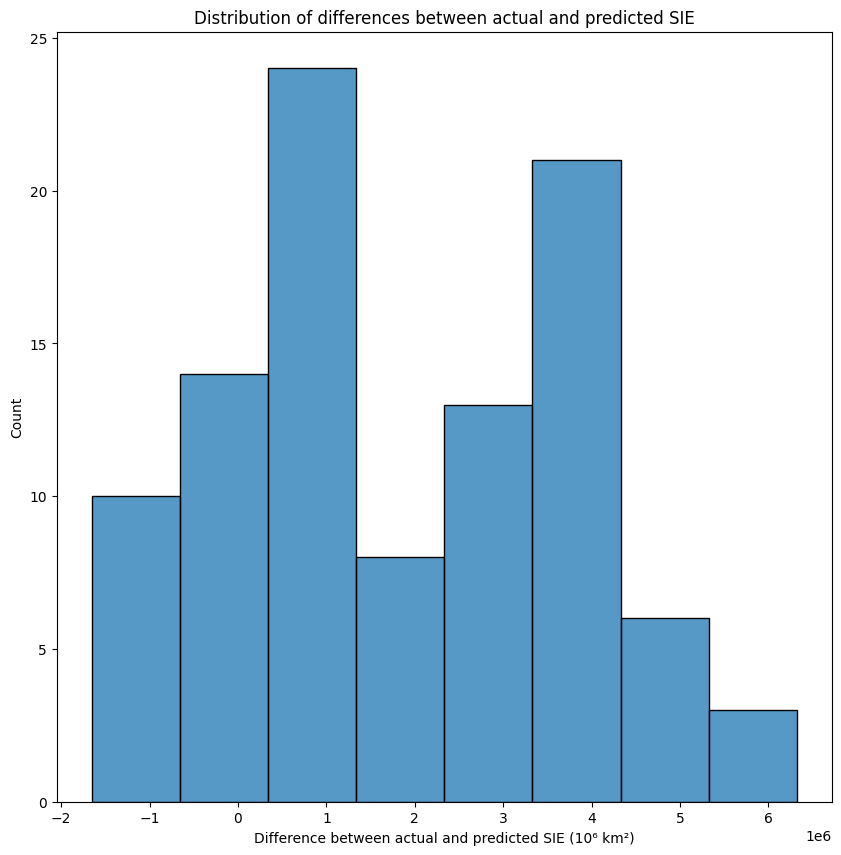

MSE :  7113141037609.149 (10⁶ km²)
MSPE : 16.547 %
RMSE :  2667047.250726756 (10⁶ km²)
RMSPE : 40.678 %
MAE :  2120153.621212121 (10⁶ km²)
MAPE :  18.465 %
R2 :  -1.686


In [13]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Actual vs Prediction Curve for Test Data', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(predictions['actual']/10**6, 'blue', label='Actual SIE')
plt.plot(predictions['predicted']/10**6, 'red', label='Predicted SIE')
plt.legend()
plt.grid()
plt.show

predictions['diff'] = predictions['predicted'] - predictions['actual']
plt.figure(figsize=(10,10))
plt.xlabel('Difference between actual and predicted SIE (10\u2076 km\u00b2)')
sns.histplot(predictions['diff'])
plt.title('Distribution of differences between actual and predicted SIE')
plt.show()

mspe = (np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values))) * 100
rmspe = (np.sqrt(np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values)))) * 100

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MSPE :", round(mspe,3), "%")
print("RMSE : ", sqrt(mean_squared_error(predictions['predicted'].values, predictions['actual'].values)), "(10\u2076 km\u00b2)")
print("RMSPE :", round(rmspe,3), "%")
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MAPE : ", round(mean_absolute_percentage_error(predictions['predicted'].values, predictions['actual'].values)*100,3), "%")
print("R2 : ", round(r2_score(predictions['predicted'].values, predictions['actual'].values)*100,3))

In [14]:
# while True:pass